In [1]:
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
dataset_root = "C:/Users/aniru/emodata/train"

In [3]:
def preprocess_data(dataset_root):
    X = []
    y = []
    
    # Define emotion labels based on folder names
    emotion_labels = sorted(os.listdir(dataset_root))
    label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
    
    # Iterate through each emotion folder
    for emotion_idx, emotion in enumerate(emotion_labels):
        emotion_dir = os.path.join(dataset_root, emotion)
        
        # Iterate through images in the folder
        for img_name in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_name)
            img = Image.open(img_path).convert('RGB')  # Convert to RGB
            img = img.resize((48, 48))  # Resize to your desired input shape
            img_array = np.array(img, dtype='float32')
            img_array = img_array / 255.0  # Normalize pixel values
            X.append(img_array)
            y.append(emotion_idx)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [7]:
X, y = preprocess_data(dataset_root)


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Add custom layers on top of VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(np.unique(y)), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=30, validation_data=(X_val, y_val))


Epoch 1/30


359/359 [==============================] - 148s 405ms/step - loss: 1.9180 - accuracy: 0.2123 - val_loss: 1.7508 - val_accuracy: 0.2954
Epoch 2/30
359/359 [==============================] - 98s 272ms/step - loss: 1.7738 - accuracy: 0.2712 - val_loss: 1.7086 - val_accuracy: 0.3285
Epoch 3/30
359/359 [==============================] - 100s 277ms/step - loss: 1.7395 - accuracy: 0.2942 - val_loss: 1.6845 - val_accuracy: 0.3459
Epoch 4/30
359/359 [==============================] - 104s 290ms/step - loss: 1.7190 - accuracy: 0.3160 - val_loss: 1.6682 - val_accuracy: 0.3476
Epoch 5/30
359/359 [==============================] - 111s 310ms/step - loss: 1.7006 - accuracy: 0.3199 - val_loss: 1.6520 - val_accuracy: 0.3567
Epoch 6/30
359/359 [==============================] - 129s 360ms/step - loss: 1.6850 - accuracy: 0.3286 - val_loss: 1.6408 - val_accuracy: 0.3612
Epoch 7/30
359/359 [==============================] - 138s 384ms/step - loss: 1.6807 - accuracy: 0.3328 - val_loss: 1.6374 

In [10]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                         epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
359/359 [==============================] - 176s 484ms/step - loss: 1.5666 - accuracy: 0.3945 - val_loss: 1.4888 - val_accuracy: 0.4403
Epoch 2/10
359/359 [==============================] - 174s 483ms/step - loss: 1.5127 - accuracy: 0.4187 - val_loss: 1.4450 - val_accuracy: 0.4559
Epoch 3/10
359/359 [==============================] - 172s 479ms/step - loss: 1.4681 - accuracy: 0.4378 - val_loss: 1.4231 - val_accuracy: 0.4605
Epoch 4/10
359/359 [==============================] - 174s 483ms/step - loss: 1.4394 - accuracy: 0.4526 - val_loss: 1.3932 - val_accuracy: 0.4768
Epoch 5/10
359/359 [==============================] - 174s 485ms/step - loss: 1.4147 - accuracy: 0.4617 - val_loss: 1.3665 - val_accuracy: 0.4821
Epoch 6/10
359/359 [==============================] - 173s 482ms/step - loss: 1.3926 - accuracy: 0.4735 - val_loss: 1.3548 - val_accuracy: 0.4901
Epoch 7/10
359/359 [==============================] - 173s 482ms/step - loss: 1.3732 - accuracy: 0.4825 - val_loss: 1.3459 -

In [11]:
model.save('emotion_detection_model.h5')

C:\Users\aniru\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')

90/90 [==============================] - 16s 173ms/step - loss: 1.2743 - accuracy: 0.5183
Test accuracy: 51.83%


In [14]:
# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))


90/90 [==============================] - 16s 174ms/step
              precision    recall  f1-score   support

           0       0.43      0.35      0.39       384
           1       0.00      0.00      0.00        46
           2       0.44      0.24      0.31       406
           3       0.61      0.81      0.70       744
           4       0.44      0.61      0.51       500
           5       0.43      0.33      0.37       485
           6       0.67      0.60      0.63       306

    accuracy                           0.52      2871
   macro avg       0.43      0.42      0.42      2871
weighted avg       0.50      0.52      0.50      2871



C:\Users\aniru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aniru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aniru\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


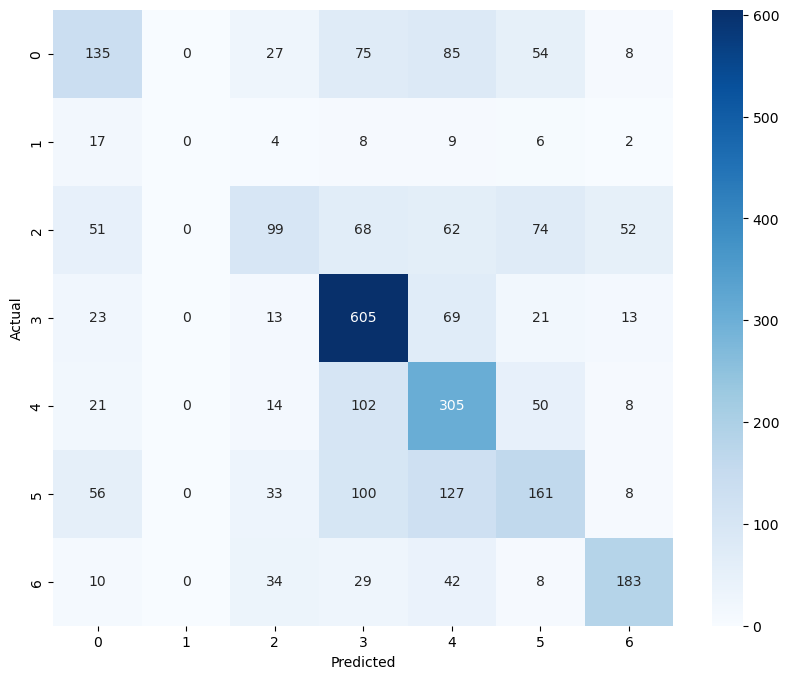

In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [2]:
# Load the trained model
model = tf.keras.models.load_model('emotion_detection_model.h5')

In [3]:
# Function to preprocess the image for Tkinter
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((48, 48))
    img_array = np.array(img)
    img_array = img_array.reshape(1, 48, 48, 3)
    img_array = img_array / 255.0
    return img_array

In [4]:
# Function to load image
def load_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path).resize((200, 200))
            img_tk = ImageTk.PhotoImage(img)
            canvas.image = img_tk
            canvas.create_image(0, 0, anchor=tk.NW, image=img_tk)
            return file_path
        except Exception as e:
            print(f"Error loading image: {e}")
            return None
    return None


In [5]:
# Function to predict sentiment
def predict_sentiment():
    img_path = load_image()
    if img_path:
        img_array = preprocess_image(img_path)
        if img_array is not None:
            prediction = model.predict(img_array)
            sentiment = np.argmax(prediction, axis=1)[0]
            emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
            result_label.config(text=f'Predicted Sentiment: {emotion_dict[sentiment]}')
        else:
            result_label.config(text='Error in image preprocessing')
    else:
        result_label.config(text='Error in loading image')

In [7]:
import cv2

# Function to preprocess a frame for real-time detection
def preprocess_frame(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img_array = np.array(img, dtype='float32')
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function for real-time emotion detection using webcam
def real_time_detection():
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    if face_cascade.empty():
        print("Error loading cascade classifier")
        return
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Failed to capture image.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            roi_color = frame[y:y+h, x:x+w]
            img_array = preprocess_frame(roi_color)
            
            prediction = model.predict(img_array)
            maxindex = int(np.argmax(prediction))

            cv2.putText(frame, emotion_dict[maxindex], (x+5, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        cv2.imshow('Real-time Emotion Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Emotion dictionary
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# Load the trained model
model = tf.keras.models.load_model('emotion_detection_model.h5')

# Set up the GUI
root = tk.Tk()
root.title("Sentiment Detection")

canvas = tk.Canvas(root, width=200, height=200)
canvas.pack()

load_button = tk.Button(root, text="Load Image", command=predict_sentiment)
load_button.pack()

real_time_button = tk.Button(root, text="Real-time Detection", command=real_time_detection)
real_time_button.pack()

result_label = tk.Label(root, text="Predicted Sentiment: ")
result_label.pack()

root.mainloop()


1/1 [==============================] - 0s 65ms/step
